In [1]:
import torch
from IPython.display import clear_output
pt_version = torch.__version__
print(pt_version)

/Users/mahim/opt/anaconda3/envs/workshop/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.13.1


In [7]:
import numpy as np
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

loader = METRLADatasetLoader()
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)

print("Dataset type:  ", dataset)
#print("Number of samples / sequences: ",  len(dataset))

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x7f89b8732760>


In [8]:
dataset[0]

Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])

In [9]:
next(iter(dataset))

Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])

In [10]:
# Important: It is not always like that!
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
d = ChickenpoxDatasetLoader().get_dataset(lags=4)
next(iter(d))

Data(x=[20, 4], edge_index=[2, 102], edge_attr=[102], y=[20])

<Axes: >

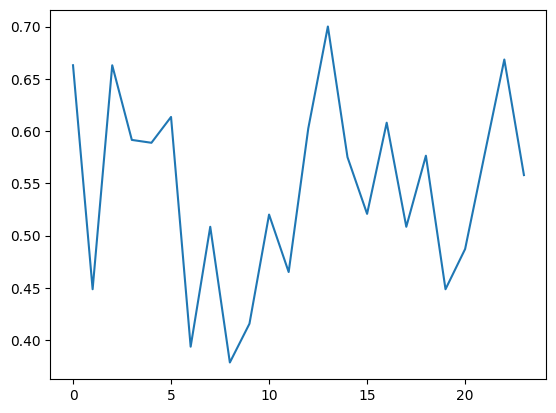

In [13]:
import seaborn as sns
# Visualize traffic over time
sensor_number = 1
hours = 24
sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:hours]]
sns.lineplot(data=sensor_labels)

In [12]:
#!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 4.2 MB/s eta 0:00:00a 0:00:01


In [23]:
from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

print("Number of train buckets: ", len(list(iter((train_dataset)))))
print("Number of test buckets: ", len(list(iter((test_dataset)))))

Number of train buckets:  27399
Number of test buckets:  6850


In [24]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features, 
                           out_channels=32, 
                           periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

TemporalGNN(node_features=2, periods=12)

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

In [ ]:
# GPU support
from tqdm import tqdm
device = torch.device('cpu') # cuda
subset = 2000

# Create model and optimizers
model = TemporalGNN(node_features=2, periods=12).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

print("Running training...")
for epoch in tqdm(range(3)): 
    loss = 0
    step = 0
    for snapshot in train_dataset:
        snapshot = snapshot.to(device)
        # Get model predictions
        y_hat = model(snapshot.x, snapshot.edge_index)
        # Mean squared error
        loss = loss + torch.mean((y_hat-snapshot.y)**2) 
        step += 1
        if step > subset:
            break

    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Epoch {} train MSE: {:.4f}".format(epoch, loss.item()))

Running training...


 10%|████▎                                      | 1/10 [01:58<17:42, 118.04s/it]

Epoch 0 train MSE: 0.7562


 20%|████████▌                                  | 2/10 [04:15<17:14, 129.29s/it]

Epoch 1 train MSE: 0.7384


 30%|████████████▉                              | 3/10 [06:17<14:43, 126.18s/it]

Epoch 2 train MSE: 0.7211


 40%|█████████████████▏                         | 4/10 [08:18<12:25, 124.23s/it]

Epoch 3 train MSE: 0.7021


 50%|█████████████████████▌                     | 5/10 [10:31<10:35, 127.15s/it]

Epoch 4 train MSE: 0.6815


 60%|█████████████████████████▊                 | 6/10 [12:25<08:11, 122.81s/it]

Epoch 5 train MSE: 0.6602


In [ ]:
model.eval()
loss = 0
step = 0
horizon = 288

# Store for analysis
predictions = []
labels = []

for snapshot in test_dataset:
    snapshot = snapshot.to(device)
    # Get predictions
    y_hat = model(snapshot.x, snapshot.edge_index)
    # Mean squared error
    loss = loss + torch.mean((y_hat-snapshot.y)**2)
    # Store for analysis below
    labels.append(snapshot.y)
    predictions.append(y_hat)
    step += 1
    if step > horizon:
          break

loss = loss / (step+1)
loss = loss.item()
print("Test MSE: {:.4f}".format(loss))